# Check training result

In [11]:
TEST_CODE = "1560756269.023654"
CHOSEN_EPOCH = 20

MODEL_PATH = "../log/{}/models/epoch_{}".format(TEST_CODE, CHOSEN_EPOCH)
LOG_PATH = "../log/{}/log.txt".format(TEST_CODE)

In [12]:
log = open(LOG_PATH).readlines()

Parameter

In [13]:
log[0]

"Namespace(base_lr=0.003, batch_size=200, decay_epoch_step=50, display_step=1, grad_clip=False, hidden_neuron=200, lambda_value=1, optimizer_method='Adam', random_seed=1000, save_step=5, train_epoch=100)\n"

In [14]:
train_log = log[1::2]
test_log = log[2::2]

In [15]:
train_cost = [float(line.split('\t')[1].replace("Total cost = ","")) for line in train_log][:-1]
test_cost = [float(line.split('\t')[1].replace("Total cost = ","")) for line in test_log]
test_RMSE = [float(line.split('\t')[2].replace("RMSE = ","")) for line in test_log]

In [16]:
n_train = int(138493 * 0.9)
n_test = int(138493 * 0.1)

train_cost = [x/n_train for x in train_cost]
test_cost = [x/n_test for x in test_cost]

## Plot

In [17]:
import matplotlib.pyplot as plt

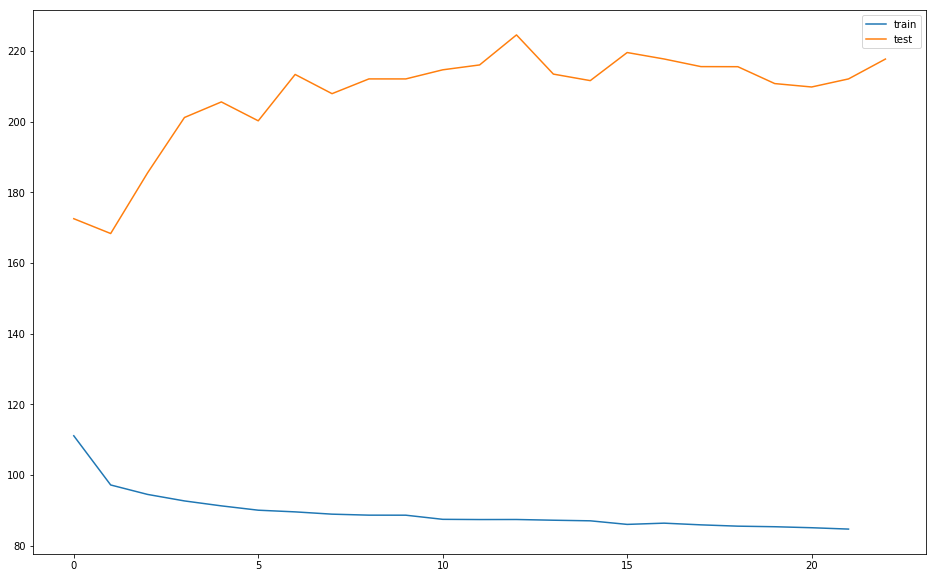

In [18]:
plt.figure(figsize=(16,10))
plt.plot(range(0, len(train_cost)), train_cost, label="train")
plt.plot(range(0, len(test_cost)), test_cost, label="test")
plt.legend()

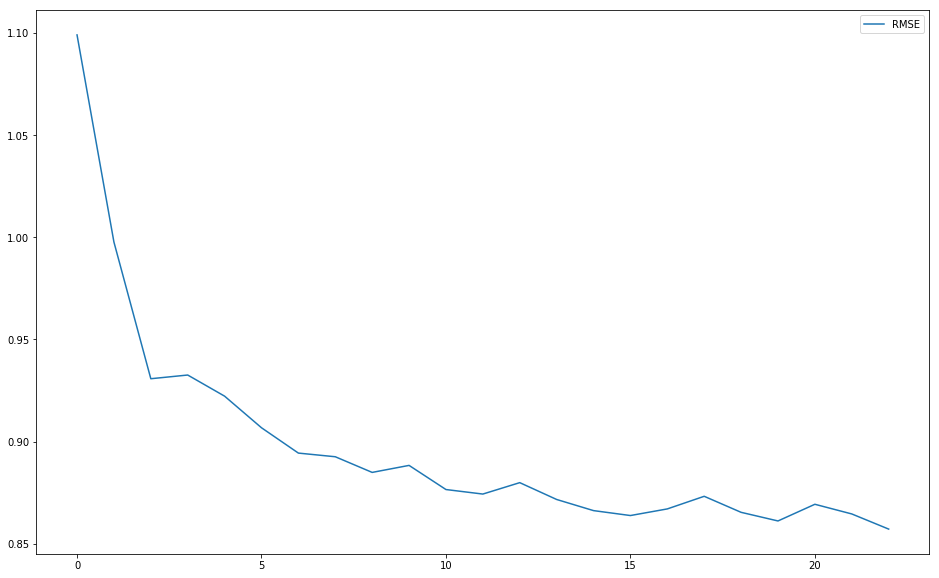

In [19]:
plt.figure(figsize=(16,10))
plt.plot(range(0, len(test_RMSE)), test_RMSE, label="RMSE")
plt.legend()

# Model

In [11]:
class Args:
    
    def __init__(self):
        self.hidden_neuron = 200
        self.lambda_value = 1.0
        
        self.train_epoch = 100
        self.batch_size = 200
        
        self.optimizer_method = 'Adam' # 'Adam','RMSProp'
        self.grad_clip = False
        self.base_lr = 0.003
        self.decay_epoch_step = 50
        
        self.random_seed = 1000
        self.display_step = 1
        self.save_step = 5
        
    def __str__(self):
        return "hidden_neuron : {}\nlambda_value : {}\ntrain_epoch : {}\nbatch_size : {}\noptimizer_method : {}\ngrad_clip : {}\nbase_lr : {}\ndecay_epoch_step : {}\nrandom_seed : {}\ndisplay_step : {}\n".format(
            self.hidden_neuron,
            self.lambda_value,
            self.train_epoch,
            self.batch_size,
            self.optimizer_method,
            self.grad_clip,
            self.base_lr,
            self.decay_epoch_step,
            self.random_seed,
            self.display_step,
            self.save_step)

args = Args()

In [12]:
import pickle
import os

class Logger:

    def set_default_filename(self, filename):
        self.default_filename = filename

    def create_session_folder(self, path):
        try:  
            os.makedirs(path)
        except OSError:  
            print ("Creation of the directory %s failed" % path)
        else:  
            print ("     ===> Successfully created the directory %s \n" % path)

    def log(self, text):
        with open(self.default_filename, 'a') as f:
            f.writelines(text)
            f.write("\n")

    def save_model(self, model, filename):
        pickle.dump(model, open(filename, 'wb'))
    
    

In [13]:
import tensorflow as tf
import time
import numpy as np
import os
import math
from datetime import datetime
from scipy.sparse import lil_matrix, csr_matrix, vstack
from tqdm import tqdm

class AutoRec():
    def __init__(self, sess, args,
                 num_users, num_items,
                 R, mask_R, train_R, train_mask_R, test_R, test_mask_R, num_train_ratings, num_test_ratings,
                 user_train_set, item_train_set, user_test_set, item_test_set):

        self.sess = sess
        self.args = args

        self.num_users = num_users
        self.num_items = num_items

        self.R = R
        self.mask_R = mask_R
        self.train_R = train_R
        self.train_mask_R = train_mask_R
        self.test_r = test_R
        self.test_mask_R = test_mask_R
        self.num_train_ratings = num_train_ratings
        self.num_test_ratings = num_test_ratings

        self.user_train_set = user_train_set
        self.item_train_set = item_train_set
        self.user_test_set = user_test_set
        self.item_test_set = item_test_set

        self.hidden_neuron = args.hidden_neuron
        self.train_epoch = args.train_epoch
        self.batch_size = args.batch_size
        self.num_batch = int(
            math.ceil(self.num_users / float(self.batch_size)))

        self.base_lr = args.base_lr
        self.optimizer_method = args.optimizer_method
        self.display_step = args.display_step
        self.random_seed = args.random_seed

        self.global_step = tf.Variable(0, trainable=False)
        self.decay_epoch_step = args.decay_epoch_step
        self.decay_step = self.decay_epoch_step * self.num_batch
        self.lr = tf.train.exponential_decay(self.base_lr, self.global_step,
                                             self.decay_step, 0.96, staircase=True)
        self.lambda_value = args.lambda_value

        self.train_cost_list = []
        self.test_cost_list = []
        self.test_rmse_list = []

        self.grad_clip = args.grad_clip
        
#         self.timestamp = str(datetime.timestamp(datetime.now()))
#         self.logger = Logger()
#         self.session_log_path = "../log/{}/".format(self.timestamp)
#         self.logger.create_session_folder(self.session_log_path)
#         self.logger.set_default_filename(self.session_log_path + "log.txt")

    def run(self):
        
        # Log parameters
        self.logger.log(str(self.args))
        self.prepare_model()
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        for epoch_itr in (range(self.train_epoch)):
            
            self.train_model(epoch_itr)
            self.test_model(epoch_itr)
            
            # Save the variables to disk.
            if epoch_itr % self.save_step == 0:
                self.saver.save(self.sess, self.session_log_path + "models/epoch_{}".format(epoch_itr))
            
        self.make_records()


    def prepare_model(self):
        self.input_R = tf.placeholder(dtype=tf.float32, shape=[
                                      None, self.num_items], name="input_R")
        self.input_mask_R = tf.placeholder(
            dtype=tf.float32, shape=[None, self.num_items], name="input_mask_R")

        V = tf.get_variable(name="V", initializer=tf.truncated_normal(shape=[self.num_items, self.hidden_neuron],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        W = tf.get_variable(name="W", initializer=tf.truncated_normal(shape=[self.hidden_neuron, self.num_items],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        mu = tf.get_variable(name="mu", initializer=tf.zeros(
            shape=self.hidden_neuron), dtype=tf.float32)
        b = tf.get_variable(name="b", initializer=tf.zeros(
            shape=self.num_items), dtype=tf.float32)

        pre_Encoder = tf.matmul(self.input_R, V) + mu
        self.Encoder = tf.nn.sigmoid(pre_Encoder)
        
        pre_Decoder = tf.matmul(self.Encoder, W) + b
        self.decoder = tf.identity(pre_Decoder)

        pre_rec_cost = tf.multiply(
            (self.input_R - self.decoder), self.input_mask_R)
        rec_cost = tf.square(self.l2_norm(pre_rec_cost))
        pre_reg_cost = tf.square(self.l2_norm(W)) + tf.square(self.l2_norm(V))
        reg_cost = self.lambda_value * 0.5 * pre_reg_cost

        self.cost = rec_cost + reg_cost

        if self.optimizer_method == "Adam":
            optimizer = tf.train.AdamOptimizer(self.lr)
        elif self.optimizer_method == "RMSProp":
            optimizer = tf.train.RMSPropOptimizer(self.lr)
        else:
            raise ValueError("Optimizer Key ERROR")

        if self.grad_clip:
            gvs = optimizer.compute_gradients(self.cost)
            capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var)
                          for grad, var in gvs]
            self.optimizer = optimizer.apply_gradients(
                capped_gvs, global_step=self.global_step)
        else:
            self.optimizer = optimizer.minimize(
                self.cost, global_step=self.global_step)
            
        self.saver = tf.train.Saver(max_to_keep=None)

    def train_model(self, itr):
        start_time = time.time()
        random_perm_doc_idx = np.random.permutation(self.num_users)

        batch_cost = 0
        for i in tqdm(range(self.num_batch)):

            if i >= self.num_batch - 1:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size:]
            else:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size: (i + 1) * self.batch_size]

            _, cost = self.sess.run(
                [self.optimizer, self.cost],
                feed_dict={self.input_R: self.train_R[batch_set_idx, :].todense(),
                           self.input_mask_R: self.train_mask_R[batch_set_idx, :].todense()})

            batch_cost = batch_cost + cost

        self.train_cost_list.append(batch_cost)

        if (itr + 1) % self.display_step == 0:
            self.logger.log(
                "Training Epoch {}\tTotal cost = {:.2f}\tElapsed time : {} sec".format(
                    itr, batch_cost, (time.time() - start_time)))
            
            print(
                "===== Training =====\n"
                "Epoch {} \t Total cost = {:.2f}\n"
                "Elapsed time : {} sec\n".format(
                    itr, batch_cost, (time.time() - start_time)))

    def test_model(self, itr):
        start_time = time.time()

        batch_cost = 0
        numerator = 0
        
        for i in tqdm(range(self.num_batch)):

            # Batching idx
            batch_start_idx = i * self.batch_size
            if i >= self.num_batch - 1:
                batch_stop_idx = batch_start_idx + \
                                 (self.num_users - 1) % self.batch_size + 1
            else:
                batch_stop_idx = (i + 1) * self.batch_size

            cost, decoder = self.sess.run(
                [self.cost, self.decoder],
                feed_dict={self.input_R: self.test_r[batch_start_idx:batch_stop_idx].todense(),
                           self.input_mask_R: self.test_mask_R[batch_start_idx:batch_stop_idx].todense()})
            
            batch_cost += cost

            # Make prediction if need to show
            if (itr + 1) % self.display_step == 0:

                batch_predict_r = csr_matrix(decoder.clip(min=0, max=1))

                # Some statistic
                predicted_rating_delta = batch_predict_r - self.test_r[batch_start_idx:batch_stop_idx]
                pre_numerator = self.test_mask_R[batch_start_idx:batch_stop_idx].multiply(predicted_rating_delta)
                numerator += np.sum(pre_numerator.data ** 2)

        self.test_cost_list.append(batch_cost)

        # Make prediction if need to show
        if (itr + 1) % self.display_step == 0:

            denominator = self.num_test_ratings
            RMSE = np.sqrt(numerator / float(denominator))
            self.test_rmse_list.append(RMSE)

            self.logger.log(
                "Testing Epoch {}\tTotal cost = {:.2f}\tRMSE = {:.5f}\tElapsed time : {} sec".format(
                    itr, batch_cost, RMSE, (time.time() - start_time)))

            print(
                "===== Testing =====\n"
                "Epoch {} \t Total cost = {:.2f}\n"
                "RMSE = {:.5f} \t Elapsed time : {} sec\n".format(
                    itr, batch_cost, RMSE, (time.time() - start_time)))

    def make_records(self):

        basic_info = self.session_log_path + "basic_info.txt"
        train_record = self.session_log_path + "train_record.txt"
        test_record = self.session_log_path + "test_record.txt"

        with open(train_record, 'w') as f:
            f.write(str("cost:"))
            f.write('\t')
            for itr in range(len(self.train_cost_list)):
                f.write(str(self.train_cost_list[itr]))
                f.write('\t')
            f.write('\n')

        with open(test_record, 'w') as g:
            g.write(str("cost:"))
            g.write('\t')
            for itr in range(len(self.test_cost_list)):
                g.write(str(self.test_cost_list[itr]))
                g.write('\t')
            g.write('\n')

            g.write(str("RMSE:"))
            for itr in range(len(self.test_rmse_list)):
                g.write(str(self.test_rmse_list[itr]))
                g.write('\t')
            g.write('\n')

        with open(basic_info, 'w') as h:
            h.write(str(self.args))

    def l2_norm(self, tensor):
        return tf.sqrt(tf.reduce_sum(tf.square(tensor)))

    
    # ============  CUSTOM FOR EVALUATION  ======================
    
    def custom_run(self):
        
        # Log parameters
        self.prepare_model()
        
#         init = tf.global_variables_initializer()
#         self.sess.run(init)
        

    def predict(self, rating, mask_rating):

        batch_cost = 0
        predict_r = csr_matrix((0, rating.shape[1]))
        num_batch = int(math.ceil(rating.shape[0] / float(self.batch_size)))
        
        for i in tqdm(range(num_batch)):

            # Batching idx
            batch_start_idx = i * self.batch_size
            if i >= self.num_batch - 1:
                batch_stop_idx = batch_start_idx + \
                                 (self.num_users - 1) % self.batch_size + 1
            else:
                batch_stop_idx = (i + 1) * self.batch_size

            cost, decoder = self.sess.run(
                [self.cost, self.decoder],
                feed_dict={self.input_R: rating[batch_start_idx:batch_stop_idx].todense(),
                           self.input_mask_R: mask_rating[batch_start_idx:batch_stop_idx].todense()})
            
            batch_cost += cost
            batch_predict_r = csr_matrix(decoder.clip(min=0, max=1)) 
            predict_r = vstack([predict_r, batch_predict_r])
            
#             print(predict_r.nonzero())
#             input()
            
        return predict_r, batch_cost

## Check Precision at K

In [14]:
filename = "../data/intersect-20m/preprocessed_autorec_dataset"
R, mask_R, train_R, train_mask_R, test_R, test_mask_R, n_train_R, n_test_R, train_users_idx, train_items_idx, test_users_idx, test_items_idx = pickle.load(open(filename, 'rb'))

In [15]:
# Try to reduce size 

rating = test_R[::25]
mask_rating = test_mask_R[::25]

## ======

In [16]:
# Random seeding
tf.set_random_seed(args.random_seed)
np.random.seed(args.random_seed)

# Detail about dataset
path = "data/intersect-20m"
num_users = 138493
num_items = 15085
train_ratio = 0.9

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [17]:
sess = tf.Session()

model = AutoRec(sess, args,
                  num_users, num_items,
                  None, None, None, None, None, None,
                  None, None, None, None, None, None)

model.custom_run()

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
model.saver = tf.train.import_meta_graph(MODEL_PATH + ".meta")
model.saver.restore(sess, MODEL_PATH)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../log/1560745848.556051/models/epoch_20


In [20]:
prediction, cost = model.predict(rating, mask_rating)

100%|██████████| 28/28 [00:21<00:00,  1.18s/it]


In [21]:
import pandas as pd

prediction_df = pd.DataFrame(prediction.todense())

In [22]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,...,15075,15076,15077,15078,15079,15080,15081,15082,15083,15084
0,0.600439,0.607899,0.707996,0.474560,0.542626,0.583830,0.706142,0.554934,0.672267,0.526683,...,0.511771,0.676650,0.767826,0.47723,0.483955,0.631451,0.579665,0.765994,0.617977,0.581518
1,0.600373,0.608525,0.708549,0.474319,0.543676,0.583452,0.706145,0.555684,0.675700,0.526705,...,0.511895,0.676163,0.772958,0.47723,0.483956,0.631451,0.579888,0.769684,0.618188,0.582653
2,0.600386,0.607739,0.708954,0.474099,0.541569,0.580728,0.706142,0.554983,0.672705,0.526866,...,0.509946,0.676369,0.769810,0.47723,0.483955,0.631451,0.579573,0.769872,0.618160,0.581886
3,0.600406,0.608173,0.708690,0.474836,0.543421,0.584084,0.706148,0.556018,0.676015,0.527039,...,0.513099,0.675362,0.771529,0.47723,0.483955,0.631451,0.579722,0.767630,0.618000,0.582445
4,0.600421,0.608818,0.708440,0.475092,0.545182,0.586896,0.706148,0.556269,0.677251,0.527062,...,0.515243,0.675867,0.773070,0.47723,0.483953,0.631451,0.579944,0.766286,0.618007,0.583040
5,0.600343,0.608482,0.708915,0.474852,0.544305,0.585750,0.706144,0.555637,0.674225,0.526682,...,0.513719,0.676618,0.771165,0.47723,0.483952,0.631451,0.579795,0.766964,0.618022,0.582414
6,0.600399,0.608375,0.708437,0.474872,0.544131,0.585397,0.706145,0.555469,0.673335,0.526791,...,0.513493,0.676342,0.770320,0.47723,0.483953,0.631451,0.579796,0.766481,0.618047,0.582197
7,0.600374,0.608443,0.708844,0.474963,0.544341,0.585629,0.706145,0.555636,0.674540,0.526741,...,0.513752,0.676288,0.771248,0.47723,0.483953,0.631451,0.579822,0.766954,0.618018,0.582356
8,0.600313,0.608118,0.709310,0.474304,0.542728,0.581800,0.706142,0.555326,0.674912,0.526505,...,0.510747,0.676006,0.771946,0.47723,0.483955,0.631451,0.579728,0.770399,0.618135,0.581937
9,0.600339,0.608198,0.709726,0.474963,0.543796,0.584956,0.706145,0.555715,0.674558,0.526894,...,0.513161,0.676027,0.770981,0.47723,0.483951,0.631451,0.579690,0.767642,0.618025,0.582253


### get list of non zeros from test data

In [23]:
nonzero = rating.nonzero()
nonzero

(array([   0,    0,    0, ..., 5539, 5539, 5539], dtype=int32),
 array([1049, 4651, 4671, ..., 5001, 5588, 8411], dtype=int32))

### find which row has rated item 11316 

In [24]:
import numpy as np
from sklearn.preprocessing import normalize

In [31]:
sample_column = prediction_df.loc[:, 4671]
sample_column = np.array(sample_column)

### Try to normalize

np.mean(sample_column)

In [32]:
# sample_column = sample_column - np.mean(sample_column)
# sample_column = sample_column * 100000

In [33]:
sample_column = sample_column.reshape(-1, 1)
sample_column.shape

(5540, 1)

### Manually rated

In [34]:
avail_rating = []
for i in range(0, len(nonzero[0])):
    if nonzero[1][i] == 11316:
        avail_rating.append(nonzero[0][i])

for x in avail_rating:
    print(sample_column[x])

[0.75892323]
[0.75591677]
[0.78167701]
[0.77391028]
[0.77567017]
[0.77400529]
[0.75730377]
[0.76241618]
[0.79802275]
[0.76138318]
[0.78392452]
[0.7442252]
[0.78623402]
[0.75908369]
[0.74144137]
[0.74258655]
[0.74913591]
[0.76048911]
[0.75514543]
[0.79454863]
[0.73447406]
[0.74463683]
[0.74408489]
[0.74182796]
[0.75488496]
[0.75923604]
[0.7492885]
[0.75013214]
[0.74694681]
[0.77794355]
[0.75089312]
[0.72620755]
[0.76915401]
[0.77376193]
[0.75516868]
[0.75758284]
[0.75178319]
[0.75252414]
[0.78144515]
[0.75276977]
[0.77836686]
[0.76046592]
[0.74469078]
[0.74794775]
[0.75660789]
[0.75875545]
[0.75860459]
[0.72593474]
[0.75160748]
[0.75954765]
[0.74255335]
[0.7513895]
[0.75702882]
[0.80796301]
[0.7572161]
[0.74958783]
[0.76166064]
[0.77862364]
[0.75303096]
[0.76565921]
[0.794267]
[0.78225082]
[0.74888408]
[0.75505459]
[0.76348972]
[0.77794266]
[0.75625986]
[0.77538437]
[0.75736642]
[0.78854096]
[0.75685519]
[0.75455356]
[0.75152683]
[0.76684296]
[0.74732214]
[0.73843235]
[0.75589883]
[0.75

### Plot

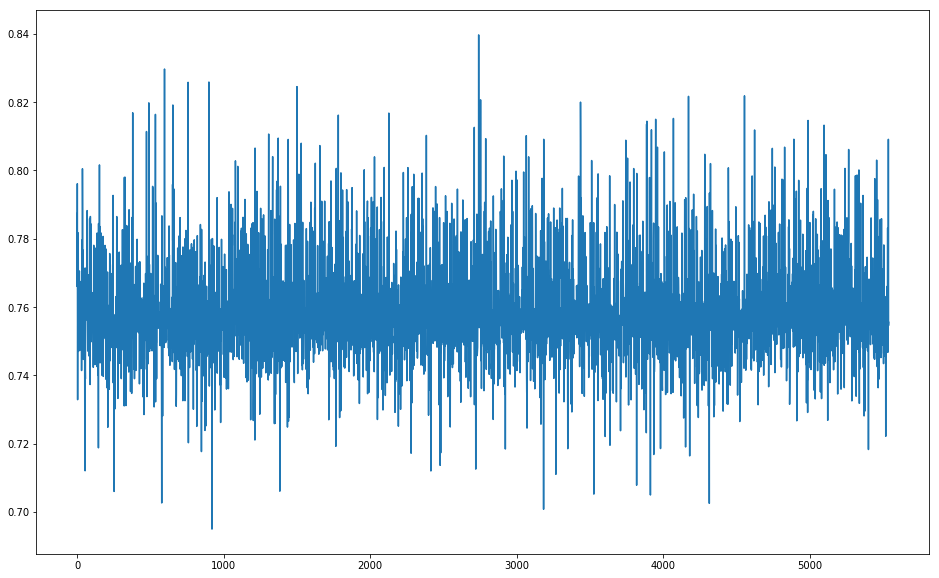

In [35]:
plt.figure(figsize=(16,10))
plt.plot(range(0, len(sample_column)), sample_column)

THE DECODER SHOULDN'T BE CLIPPED AT 0.2 ??

THOSE RATED > 0.3 MOSLTY IS TRAIN DATA (RATED) NOT GENERATED..

if not clipped stuck at weird position (?) 

# Sort rating

In [75]:
def getIndices(user, qua, offset):
    return set(prediction_df.iloc[user].sort_values(ascending=False)[offset:offset+qua].index)
#     return prediction_df.iloc[user].sort_values(ascending=False)[:qua]

In [98]:
isect = getIndices(np.random.randint(1,200),10, 200)
print(sorted(isect))
for i in range(10):
    st = getIndices(np.random.randint(1,200),10, 200)
    print(sorted(st))
    isect = isect.intersection(st)
print(sorted(isect),len(isect))

[1151, 1394, 3943, 4177, 4418, 7600, 8348, 9636, 13181, 13598]
[4177, 4418, 5879, 6312, 6672, 7600, 7702, 8348, 11958, 13181]
[1394, 4177, 4418, 7600, 8348, 9636, 11600, 13181, 13598, 14350]
[1394, 2685, 4177, 4418, 7600, 8348, 9636, 13181, 13598, 14350]
[1394, 3943, 4177, 4418, 7600, 8348, 8574, 13181, 13598, 14350]
[1394, 2685, 4177, 7600, 7702, 8348, 9636, 13181, 13598, 14350]
[1394, 3943, 4418, 7600, 8348, 8574, 11600, 13181, 13598, 14350]
[1394, 3943, 4177, 4418, 7600, 8348, 9636, 13181, 13598, 14350]
[1394, 3943, 4418, 7600, 8348, 8574, 11600, 13181, 13598, 14350]
[1394, 2685, 4177, 4418, 7600, 8348, 9636, 13181, 13598, 14350]
[1394, 3943, 4177, 4418, 7600, 8348, 9636, 13181, 13598, 14350]
[7600, 8348, 13181] 3


In [100]:
prediction_df.iloc[500].sort_values(ascending=False)[0:10]

13247    1.000000
10770    1.000000
13046    1.000000
12801    1.000000
14526    1.000000
8937     0.999987
6491     0.999982
14651    0.999972
10417    0.999958
1980     0.999957
Name: 500, dtype: float64

In [77]:
getIndices(np.random.randint(1,200),10, 500)

{4278, 5252, 7707, 8731, 10113, 11568, 11934, 12953, 14504, 14636}

In [66]:
prediction_df[1993]

0       0.953406
1       0.952887
2       0.953428
3       0.952636
4       0.952453
5       0.953254
6       0.953106
7       0.953152
8       0.953530
9       0.953410
10      0.952185
11      0.953313
12      0.953185
13      0.953061
14      0.953450
15      0.952942
16      0.952561
17      0.953223
18      0.953847
19      0.953119
20      0.952850
21      0.953528
22      0.953251
23      0.953369
24      0.952804
25      0.953071
26      0.952804
27      0.953138
28      0.953237
29      0.953237
          ...   
5510    0.953075
5511    0.953220
5512    0.953286
5513    0.953151
5514    0.953212
5515    0.953402
5516    0.953075
5517    0.953431
5518    0.953197
5519    0.953877
5520    0.953018
5521    0.953003
5522    0.953174
5523    0.953237
5524    0.953222
5525    0.953103
5526    0.953101
5527    0.953248
5528    0.952353
5529    0.952719
5530    0.951792
5531    0.952973
5532    0.954425
5533    0.952789
5534    0.952910
5535    0.953067
5536    0.953125
5537    0.9529

In [108]:
R[:, 13247].nonzero()

(array([59416], dtype=int32), array([0], dtype=int32))

In [104]:
train_R[12801, 6671]

array(0.)

In [121]:
train_R[21060:21070, 5700:5710].todense()

matrix([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.7, 0. , 0. , 5. , 0. , 0. , 0. , 0. ]])

In [116]:
train_R.argmax()

317831570

In [119]:
train_R[0,:]

<1x15085 sparse matrix of type '<class 'numpy.float64'>'
	with 110 stored elements in Compressed Sparse Row format>

In [120]:
(317831570/15085,317831570%15085)

(21069.378190255222, 5705)